In [1]:
from typing import Tuple

import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import warnings

from sklearn.decomposition import PCA

from src.piccard.piccard2 import cluster_count_plot

warnings.filterwarnings('ignore')

import piccard as pc
import piccard2 as pc2

# needed if methods brought in
from tscluster.opttscluster import OptTSCluster
from tscluster.greedytscluster import GreedyTSCluster
from tscluster.preprocessing.utils import load_data, ntf_to_tnf, tnf_to_ntf
import pandas as pd
import math
import networkx as nx

In [2]:
households_data_2021 = gpd.read_file("data_testing/households_data_2021.geojson")
households_data_2016 = gpd.read_file("data_testing/households_data_2016.geojson")
households_data_2011 = gpd.read_file("data_testing/households_data_2011.geojson")
households_data_2006 = gpd.read_file("data_testing/households_data_2006.geojson")

households_data_2021.rename(columns={'v_CA21_434: Occupied private dwellings by structural type of dwelling data': 'occupied_private_dwellings',
                                     'v_CA21_435: Single-detached house': 'single_detached_house',
                                     'v_CA21_440: Apartment in a building that has five or more storeys': 'apt_five_or_more'}, inplace=True)
households_data_2016.rename(columns={'v_CA16_408: Occupied private dwellings by structural type of dwelling data': 'occupied_private_dwellings',
                                     'v_CA16_409: Single-detached house': 'single_detached_house',
                                     'v_CA16_410: Apartment in a building that has five or more storeys': 'apt_five_or_more'}, inplace=True)
households_data_2011.rename(columns={'v_CA11F_199: Total number of occupied private dwellings by structural type of dwelling': 'occupied_private_dwellings',
                                     'v_CA11F_200: Single-detached house': 'single_detached_house',
                                     'v_CA11F_201: Apartment, building that has five or more storeys': 'apt_five_or_more',}, inplace=True)
households_data_2006.rename(columns={'v_CA06_119: Total number of occupied private dwellings by structural type of dwelling - data': 'occupied_private_dwellings',
                                     'v_CA06_120: Single-detached house': 'single_detached_house',
                                     'v_CA06_124: Apartment, building that has five or more storeys': 'apt_five_or_more',}, inplace=True)

In [3]:
census_dfs = [households_data_2006, households_data_2011, households_data_2016, households_data_2021]
years = ['2006', '2011', '2016', '2021']

network_table = pc.create_network_table(census_dfs, years, 'GeoUID')
network_table

,geouid_2006,geouid_2011,geouid_2016,geouid_2021,shape area_2006,quality flags_2006,type_2006,households_2006,pr_uid_2006,dwellings_2006,...,region name_2021,area (sq km)_2021,occupied_private_dwellings_2021,single_detached_house_2021,apt_five_or_more_2021,name_2021,dwellings 2016_2021,population 2016_2021,households 2016_2021,network_level_2021
0,2006_5350001.00,2011_5350001.00,2016_5350001.00,2021_5350001.00,6.62223,01000,CT,231,35,245,...,0001.00,6.8192,235.0,15.0,0.0,0001.00,274.0,595.0,247.0,4
1,2006_5350002.00,2011_5350002.00,2016_5350002.00,2021_5350002.00,3.26165,00010,CT,262,35,273,...,0002.00,3.3926,285.0,250.0,0.0,0002.00,279.0,620.0,270.0,4
2,2006_5350003.00,2011_5350003.00,2016_5350003.00,2021_5350003.00,0.93043,None,CT,1,35,1,...,0003.00,0.9455,265.0,0.0,265.0,0003.00,267.0,749.0,258.0,4
3,2006_5350004.00,2011_5350004.00,2016_5350004.00,2021_5350004.00,0.34390,02020,CT,3335,35,3614,...,0004.00,0.3404,3275.0,70.0,1790.0,0004.00,3609.0,6686.0,3455.0,4
4,2006_5350005.00,2011_5350005.00,2016_5350005.00,2021_5350005.00,0.37841,01010,CT,2413,35,2575,...,0005.00,0.3764,3720.0,40.0,2420.0,0005.00,3729.0,6424.0,3424.0,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
582,2006_5350378.22,2011_5350378.22,2016_5350378.22,2021_5350378.22,0.53116,00000,CT,862,35,880,...,0378.22,0.5321,870.0,800.0,0.0,0378.22,891.0,3454.0,877.0,4
583,2006_5350378.23,2011_5350378.23,2016_5350378.23,2021_5350378.23,1.53841,00001,CT,1282,35,1309,...,0378.23,1.5314,1280.0,635.0,325.0,0378.23,1334.0,4095.0,1302.0,4
584,2006_5350378.24,2011_5350378.24,2016_5350378.24,2021_5350378.24,2.52091,00011,CT,1861,35,1947,...,0378.24,2.5129,2125.0,450.0,820.0,0378.24,2218.0,6109.0,2147.0,4
585,2006_5350802.01,2011_5350802.01,2016_5350802.01,2021_5350802.01,2.22576,00000,CT,1242,35,1269,...,0802.01,2.1742,1305.0,810.0,0.0,0802.01,1290.0,3829.0,1267.0,4


In [ ]:
from tscluster.tsplot import tsplot 

arr, label_dict = pc2.clustering_prep(network_table, 'name', [
    'occupied_private_dwellings_2006', 'single_detached_house_2006', 'apt_five_or_more_2006',
    'occupied_private_dwellings_2011', 'single_detached_house_2011', 'apt_five_or_more_2011',
    'occupied_private_dwellings_2016', 'single_detached_house_2016', 'apt_five_or_more_2016', 
    'occupied_private_dwellings_2021', 'single_detached_house_2021', 'apt_five_or_more_2021'])

fig, ax = tsplot.plot(X=arr, label_dict=label_dict)

In [ ]:
# we will use the elbow method to determine the optimal number of clusters
from sympy import false
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans

reshaped_arr = arr.reshape(587*4,3)
reshaped_arr = np.nan_to_num(reshaped_arr, nan=-1000000)

model = KMeans(random_state=4,n_init=10)
visualizer = KElbowVisualizer(model, k=(2,10),timings=False, ax=plt.gca())
visualizer.fit(reshaped_arr)       # Fit data to visualizer
plt.title('Elbow Method for Optimal k using Sum of Square Error')
plt.xlabel('k')
plt.ylabel('Sum of Squared Error')
plt.show()

In [ ]:
G = pc.create_network(census_dfs, years, 'GeoUID', 0.05)
tsc = pc2.cluster(network_table, G, 'GeoUID', 4, arr=arr, label_dict=label_dict)

In [ ]:
network_table.head(20)
pd.DataFrame(network_table).to_csv("Clustered_network.csv", index=False)

In [ ]:
list(G.nodes(data=True))[:3]

In [ ]:
import piccard2 as pc2
pc2.plot_clusters(network_table, tsc)

In [ ]:
figure = pc2.parallel_plot(network_table,'cluster_assignment', years,height=600)
figure.show()

In [ ]:
pc2.cluster_count_plot(network_table, 'cluster_assignment', years, x_label='Year', y_label='Number of Census Tracts', figure_size=(10,5), stacked=True)

In [ ]:
for year in years:
    network_table[f'cluster_assignment_{year}'] = network_table[f'cluster_assignment_{year}'].astype(str)

In [ ]:
# Plot for each year
for year in ['2006', '2011', '2016', '2021']:
    gdf = pc2.join_geometries(f"data_testing/households_data_{year}.geojson",network_table, year,"GeoUID","geouid")
    pc2.clustered_map_plot(year, cluster_col_prefix="cluster_assignment", gdf=gdf)

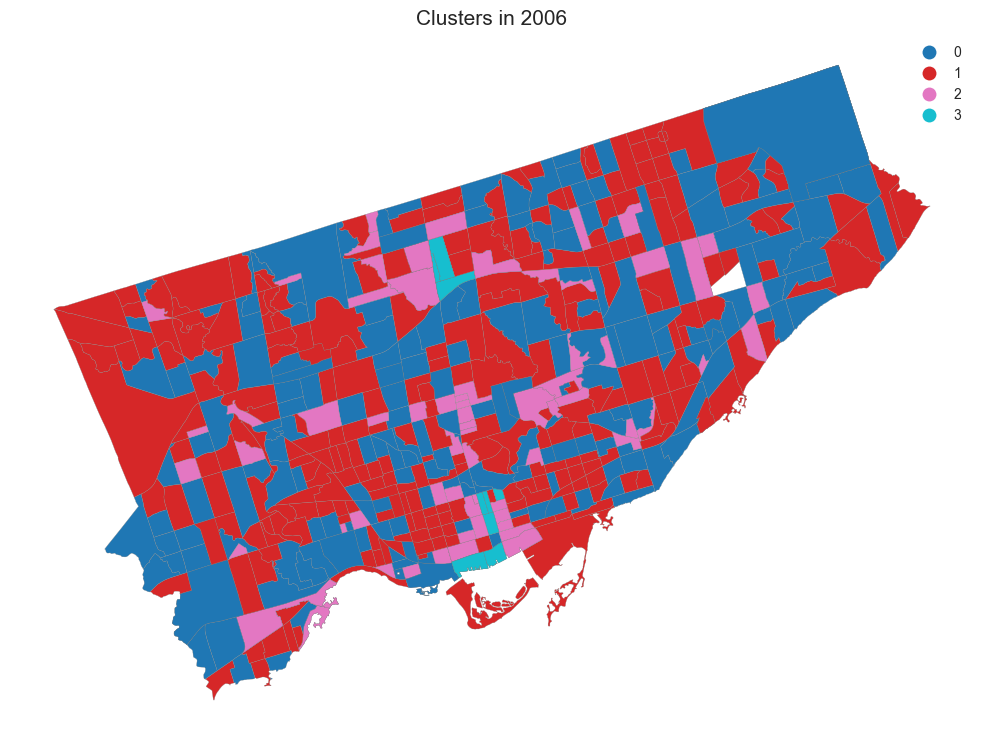

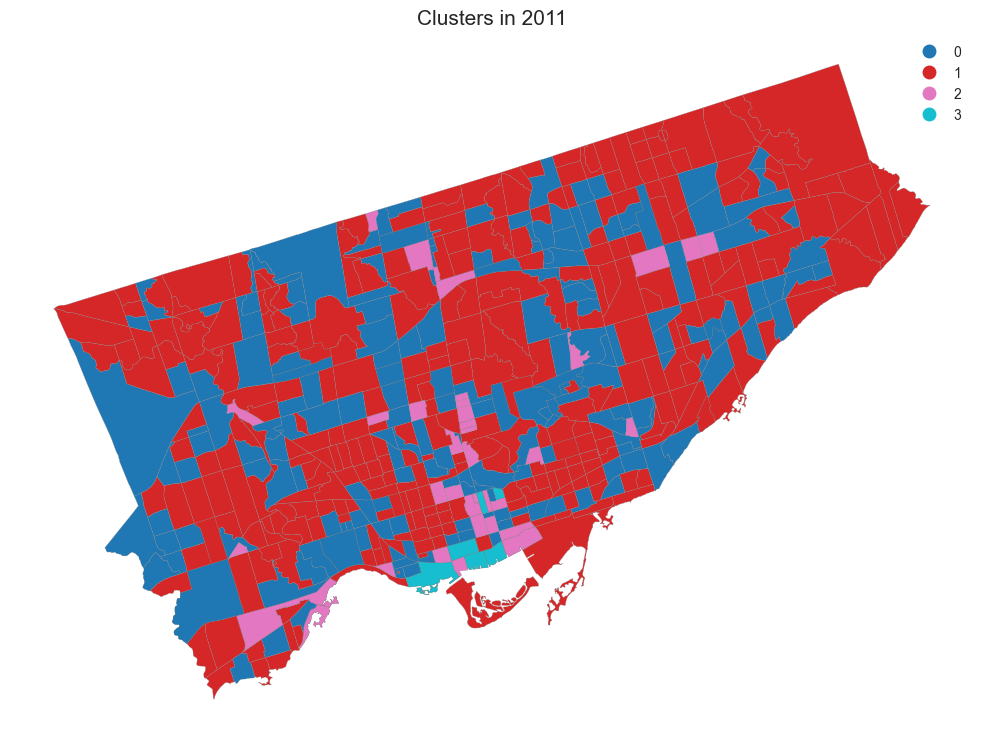

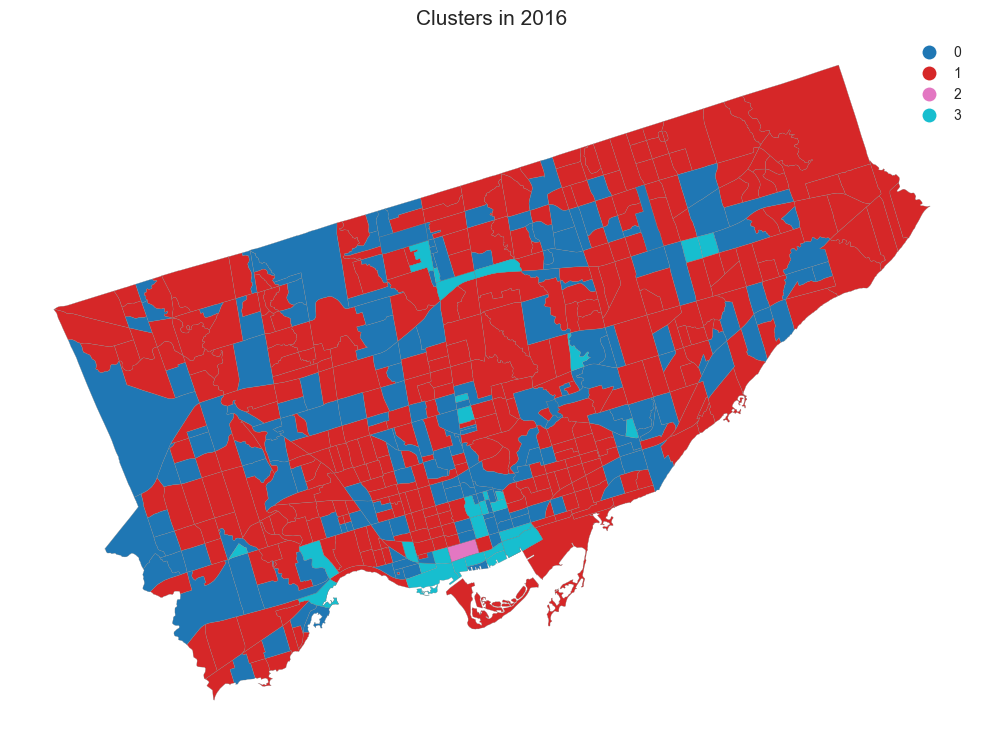

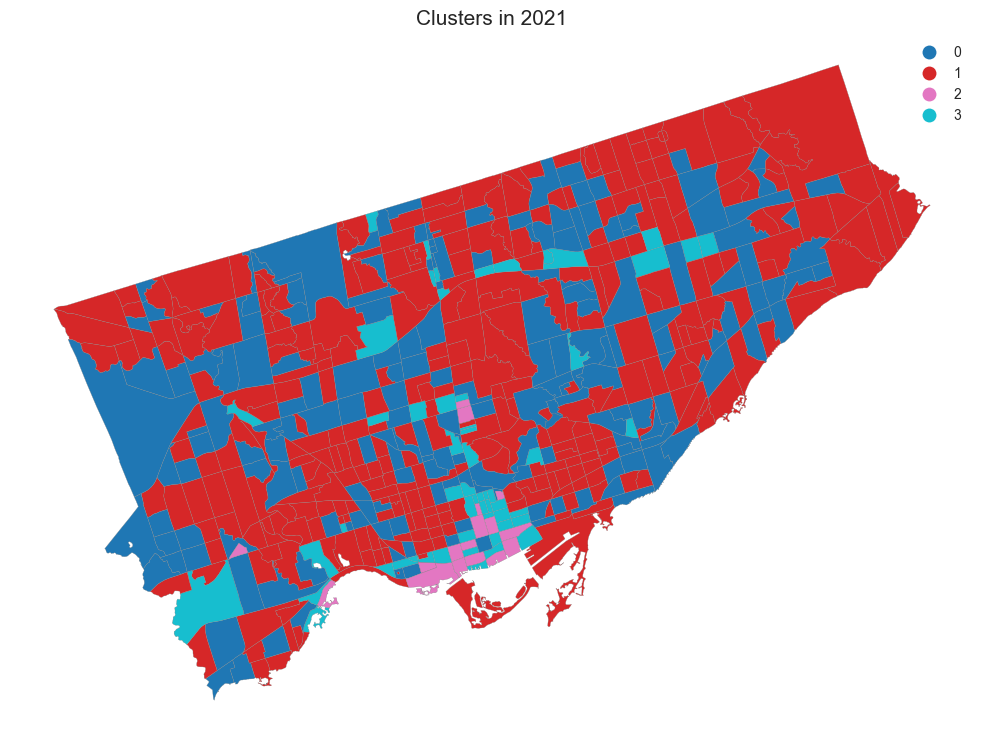

In [100]:
for year in ['2006', '2011', '2016', '2021']:
    pc2.clustered_map_plot(
        year=year,
        cluster_col_prefix='cluster_assignment',
        geojson_path=f"data_testing/households_data_{year}.geojson",
        network_table=network_table
    )

In [ ]:
#     'occupied_private_dwellings_2006', 'single_detached_house_2006', 'apt_five_or_more_2006',
#    'occupied_private_dwellings_2011', 'single_detached_house_2011', 'apt_five_or_more_2011',
#    'occupied_private_dwellings_2016', 'single_detached_house_2016', 'apt_five_or_more_2016', 
#    'occupied_private_dwellings_2021', 'single_detached_house_2021', 'apt_five_or_more_2021'])

In [66]:
# list out all twelve of your variables
cols = [
    'occupied_private_dwellings', 'single_detached_house', 'apt_five_or_more',
]
for year in years:
    prepared_cols = [f'{col}_{year}' for col in cols]
    means_per_cluster = network_table.groupby(f'cluster_assignment_{year}')[prepared_cols].mean()
    
    print(means_per_cluster)


                         occupied_private_dwellings_2006  \
cluster_assignment_2006                                    
0                                            2202.440758   
1                                            1289.022556   
2                                            2971.882353   
3                                            4953.571429   

                         single_detached_house_2006  apt_five_or_more_2006  
cluster_assignment_2006                                                     
0                                        681.137441             755.616114  
1                                        489.924812             197.518797  
2                                        269.411765            2172.352941  
3                                        202.142857            4326.904762  
                         occupied_private_dwellings_2011  \
cluster_assignment_2011                                    
0                                            2296.577670 

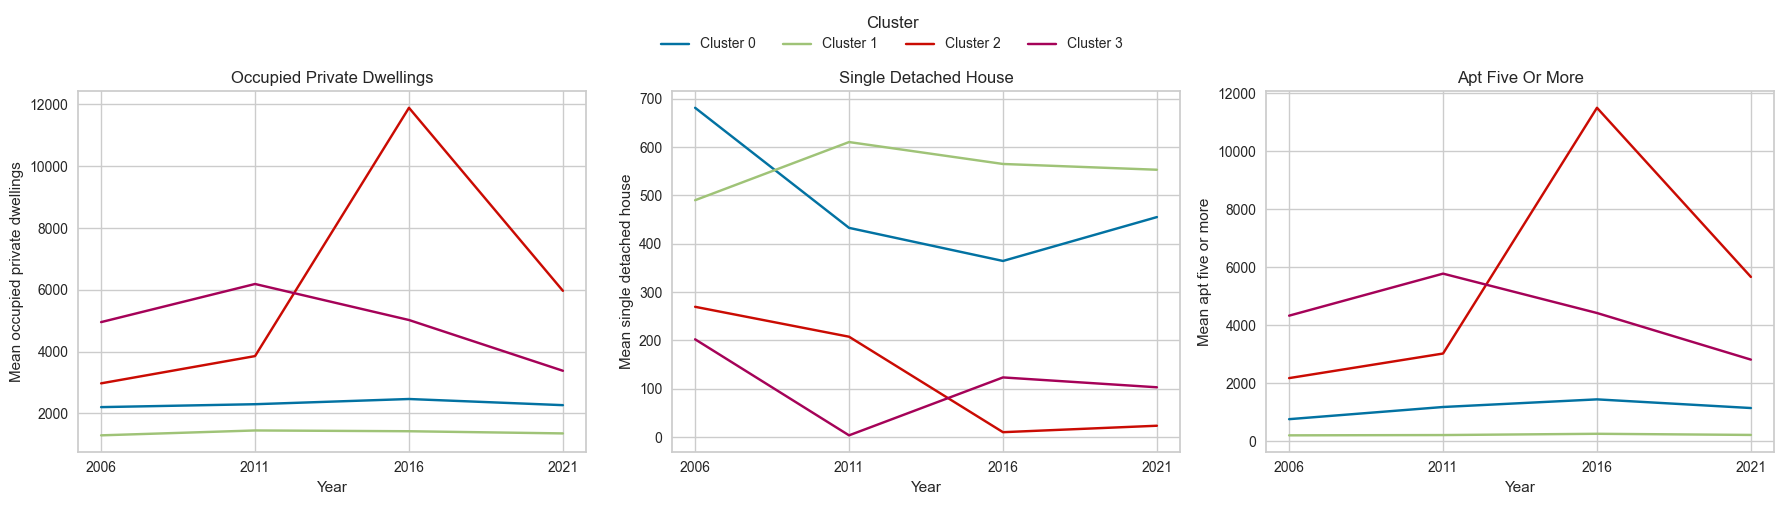

  apt_five_or_more                                          \
              2006         2011          2016         2021   
0       755.616114  1175.485437   1439.010417  1139.896373   
1       197.518797   207.389937    251.065341   211.771160   
2      2172.352941  3020.520833  11500.000000  5663.611111   
3      4326.904762  5777.307692   4418.947368  2810.263158   

  occupied_private_dwellings                                          \
                        2006         2011          2016         2021   
0                2202.440758  2296.577670   2465.026042  2266.036269   
1                1289.022556  1447.106918   1421.960227  1351.520376   
2                2971.882353  3854.062500  11890.000000  5966.666667   
3                4953.571429  6187.692308   5021.578947  3378.596491   

  single_detached_house                                      
                   2006        2011        2016        2021  
0            681.137441  432.718447  364.244792  455.025907  
1       

In [94]:
import pandas as pd
import matplotlib.pyplot as plt

years     = [2006, 2011, 2016, 2021]
base_cols = ['occupied_private_dwellings', 'single_detached_house', 'apt_five_or_more']

# 1) build a per-year DataFrame whose columns are just the base names:
dfs = {}
for year in years:
    df = (
        network_table
        .groupby(f'cluster_assignment_{year}')
        [[f'{col}_{year}' for col in base_cols]]
        .mean()
        .rename(columns={f'{col}_{year}': col for col in base_cols})
    )
    dfs[year] = df

# 2) concatenate so that MultiIndex columns = (variable, year)
means_all = pd.concat(dfs, axis=1)
means_all = means_all.swaplevel(0, 1, axis=1).sort_index(axis=1)

# 3) make a 1×3 grid of subplots
fig, axes = plt.subplots(1, len(base_cols), figsize=(18, 5), squeeze=False)
axes = axes.flatten()

for ax, var in zip(axes, base_cols):
    df_var = means_all[var]   # now first‐level col = var
    for cluster in df_var.index:
        ax.plot(
            df_var.columns.astype(int),    # [2006,2011,2016,2021]
            df_var.loc[cluster],
            label=f'Cluster {cluster}'
        )
    ax.set_title(var.replace('_',' ').title())
    ax.set_xlabel('Year')
    ax.set_ylabel(f"Mean {var.replace('_',' ')}")
    
    ax.set_xticks(years)
    ax.set_xticklabels([str(y) for y in years])

# grab handles/labels from first subplot
handles, labels = axes[0].get_legend_handles_labels()

# place one legend above all subplots
fig.legend(
    handles, labels,
    title='Cluster',
    loc='upper center',
    ncols=len(labels),
    bbox_to_anchor=(0.5, 1.02)
)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()
print(means_all)


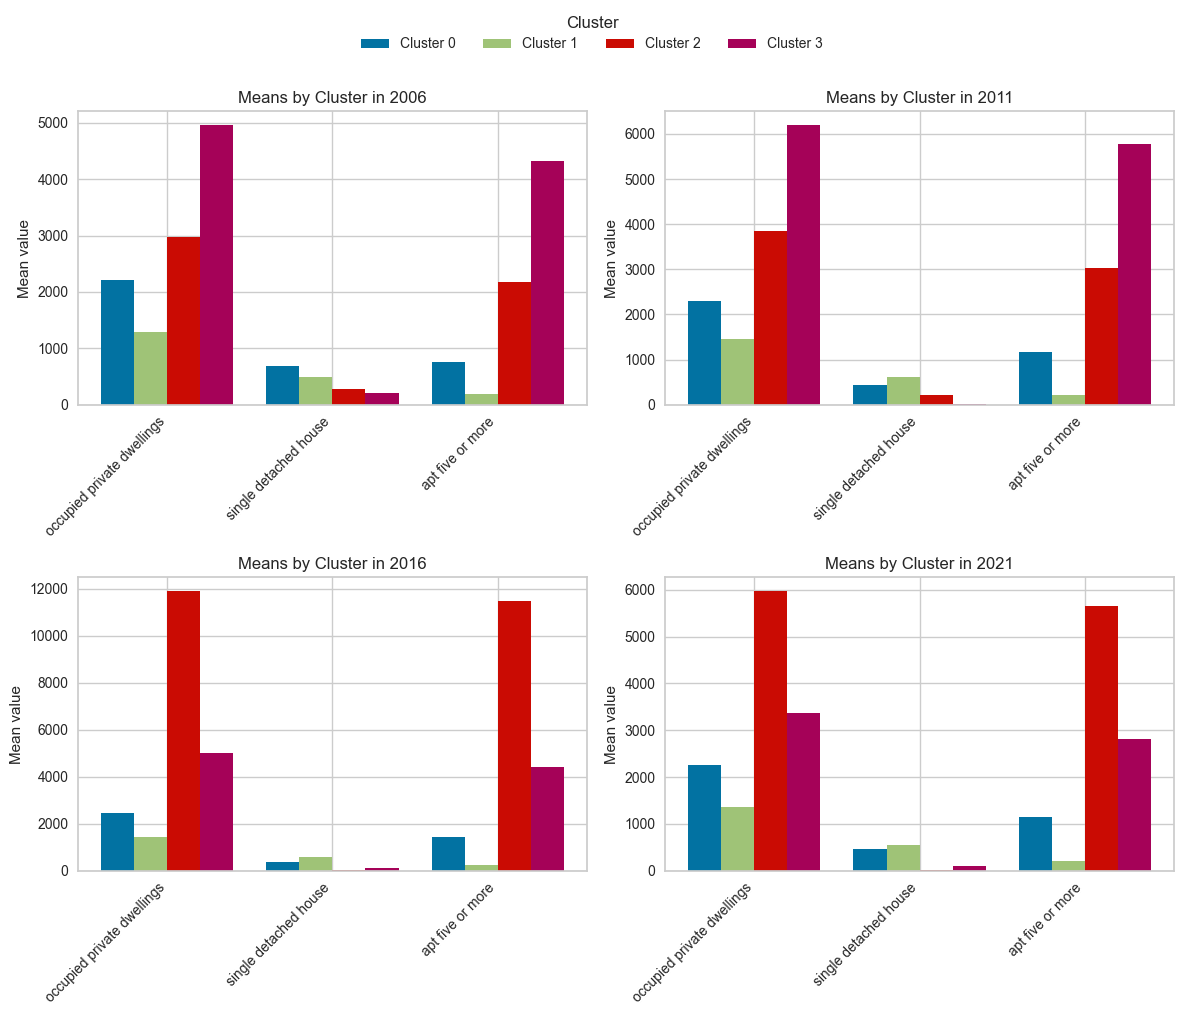

  apt_five_or_more                                          \
              2006         2011          2016         2021   
0       755.616114  1175.485437   1439.010417  1139.896373   
1       197.518797   207.389937    251.065341   211.771160   
2      2172.352941  3020.520833  11500.000000  5663.611111   
3      4326.904762  5777.307692   4418.947368  2810.263158   

  occupied_private_dwellings                                          \
                        2006         2011          2016         2021   
0                2202.440758  2296.577670   2465.026042  2266.036269   
1                1289.022556  1447.106918   1421.960227  1351.520376   
2                2971.882353  3854.062500  11890.000000  5966.666667   
3                4953.571429  6187.692308   5021.578947  3378.596491   

  single_detached_house                                      
                   2006        2011        2016        2021  
0            681.137441  432.718447  364.244792  455.025907  
1       

In [96]:
import numpy as np
import matplotlib.pyplot as plt

years     = [2006, 2011, 2016, 2021]
base_vars = ['occupied_private_dwellings', 'single_detached_house', 'apt_five_or_more']

fig, axes = plt.subplots(2, 2, figsize=(12, 10), squeeze=False)
axes = axes.flatten()

x = np.arange(len(base_vars))
width = 0.2

for ax, year in zip(axes, years):
    # grab the means for this year
    df_year = means_all.xs(year, axis=1, level=1)
    # **reorder** to your base_vars sequence
    df_year = df_year[base_vars]

    for i, cluster in enumerate(df_year.index):
        ax.bar(x + i*width,
               df_year.loc[cluster],
               width,
               label=f'Cluster {cluster}')

    ax.set_xticks(x + width*(len(df_year.index)-1)/2)
    ax.set_xticklabels([v.replace('_',' ') for v in base_vars], rotation=45, ha='right')
    ax.set_title(f'Means by Cluster in {year}')
    ax.set_ylabel('Mean value')

# now grab handles & labels from the *first* subplot only
handles, labels = axes[0].get_legend_handles_labels()

# place one legend for the entire figure
fig.legend(
    handles, labels,
    title='Cluster',
    loc='upper center',
    ncols=len(labels),
    bbox_to_anchor=(0.5, 1.02)
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
print(means_all)
